In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report, f1_score, precision_recall_curve, roc_auc_score, roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

# Exploring classification metrics

### Dataset for demonstration 

Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.

### Loading the data

In [2]:
cc_df = pd.read_csv("../data/creditcard.csv", encoding="latin-1")
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00,0
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49,0
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74,0
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52,0
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50,0


In [3]:
X_train_big, y_train_big = train_df.drop(columns=["Class", "Time"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class", "Time"]), test_df["Class"]
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.7, random_state=123
)

## Comparing PR curves

Let's create PR curves for SVC and Logisitic Regression

In [7]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [8]:
pipe_svc = make_pipeline(StandardScaler(), SVC())
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [9]:
pipe_lr.predict_proba(X_valid)

array([[9.99807444e-01, 1.92556242e-04],
       [9.99537296e-01, 4.62703836e-04],
       [9.99678149e-01, 3.21851032e-04],
       ...,
       [9.99907898e-01, 9.21018764e-05],
       [9.99882185e-01, 1.17814723e-04],
       [9.99845434e-01, 1.54565766e-04]])

In [11]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
    y_valid, pipe_lr.predict_proba(X_valid)[:, 1]
)

In [12]:
thresholds_lr

array([5.43344135e-10, 8.87215534e-10, 1.13373820e-09, ...,
       9.99999990e-01, 9.99999996e-01, 1.00000000e+00])

In [14]:
pipe_svc.decision_function(X_valid)

array([-1.12247976, -1.15220481, -1.05407669, ..., -1.18444729,
       -1.06337006, -1.05482241])

In [16]:
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(
    y_valid, pipe_svc.decision_function(X_valid)
)

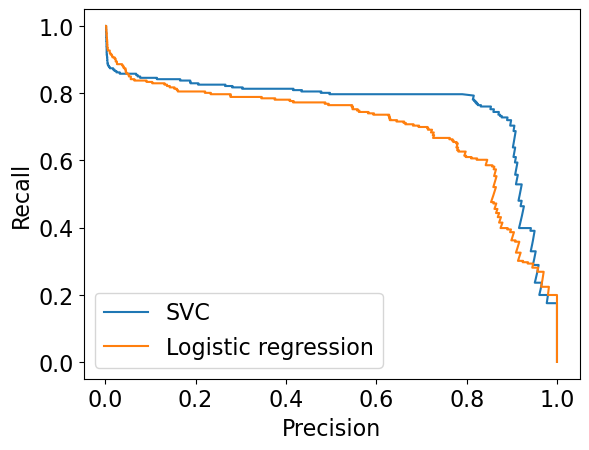

In [17]:
plt.plot(precision_svc, recall_svc, label="SVC")
plt.plot(precision_lr, recall_lr, label="Logistic regression")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best");

### Let's look at the F1 scores

In [18]:
lr_f1 = f1_score(y_valid, pipe_lr.predict(X_valid))
svc_f1 = f1_score(y_valid, pipe_svc.predict(X_valid))

print(lr_f1, svc_f1)

0.6463104325699746 0.553314121037464


### What about the average precision score

In [19]:
lr_ap = average_precision_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
svc_ap = average_precision_score(y_valid, pipe_svc.decision_function(X_valid))

print(lr_ap, svc_ap)

0.698147830641323 0.7629107575877127


## Comparing ROC curves

Let's look at the ROC curve for Logistic Regression first

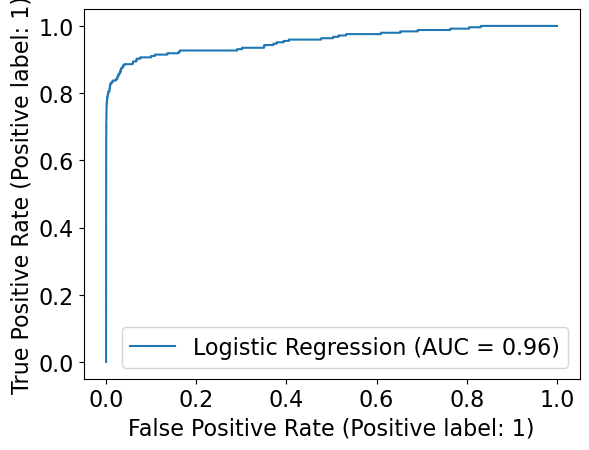

In [20]:
RocCurveDisplay.from_estimator(pipe_lr, X_valid, y_valid, name="Logistic Regression")

But what if we want to plot more than one classifier? Let's look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_estimator).

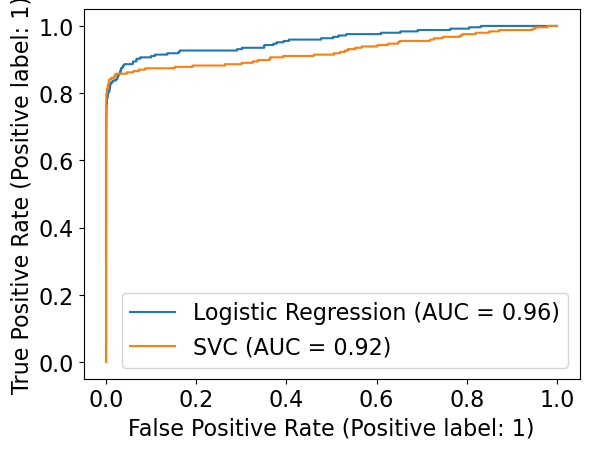

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
RocCurveDisplay.from_estimator(pipe_lr, X_valid, y_valid, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(pipe_svc, X_valid, y_valid, ax=ax, name="SVC")

## Comparing class_weight

Let's explore how the `class_weight` argument impacts performance.

In [27]:
# Standard LogisticRegression
pipe_lr_std = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
pipe_lr_std.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [28]:
# Giving a weight of 1 to the non-fraud and 10 to fraud examples
pipe_lr_upw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, class_weight={0:1, 1:10}))
pipe_lr_upw.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 1, 1: 10}, max_iter=500))])

In [29]:
# Balanced weights
pipe_lr_balanced = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, class_weight="balanced"))
pipe_lr_balanced.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

First let's look at the precision-recall curves

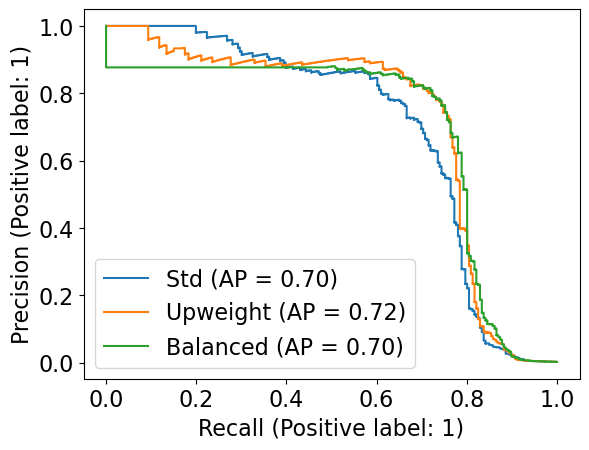

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
PrecisionRecallDisplay.from_estimator(pipe_lr_std, X_valid, y_valid, ax=ax, name="Std")
PrecisionRecallDisplay.from_estimator(pipe_lr_upw, X_valid, y_valid, ax=ax, name="Upweight")
PrecisionRecallDisplay.from_estimator(pipe_lr_balanced, X_valid, y_valid, ax=ax, name="Balanced")

Now let's consider the ROC curves

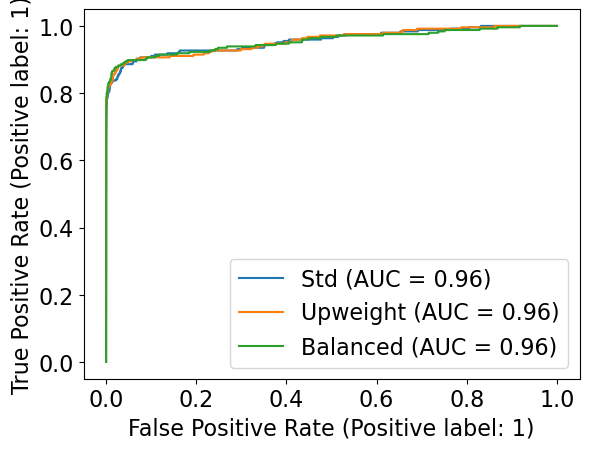

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
RocCurveDisplay.from_estimator(pipe_lr_std, X_valid, y_valid, ax=ax, name="Std")
RocCurveDisplay.from_estimator(pipe_lr_upw, X_valid, y_valid, ax=ax, name="Upweight")
RocCurveDisplay.from_estimator(pipe_lr_balanced, X_valid, y_valid, ax=ax, name="Balanced")

# ML fairness activity

AI/ML systems can give the illusion of objectivity as they are derived from seemingly unbiased data & algorithm. However, human are inherently biased and AI/ML systems, if not carefully evaluated, can even further amplify the existing inequities and systemic bias in our society.  

How do we make sure our AI/ML systems are *fair*? Which metrics can we use to quatify 'fairness' in AI/ML systems?

### Dataset for demonstration 

Let's examine this on [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [ ]:
census_df = pd.read_csv("../data/adult.csv")
census_df.shape

In [ ]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

### Data cleaning

In [ ]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

In [ ]:
train_df_nan.head()

In [ ]:
numeric_features = [
    "age",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "native.country",
]

ordinal_features = ["education"]
binary_features = [
    "sex"
]  # Not binary in general but in this particular dataset it seems to have only two possible values
drop_features = ["education.num", "fnlwgt"]
target = "income"

In [ ]:
train_df["education"].unique()

In [ ]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [ ]:
assert set(education_levels) == set(train_df["education"].unique())

In [ ]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [ ]:
y_train.value_counts()

Let's build our classification pipeline

In [ ]:
pipe_lr = 

And look at the confustion matrix

Let's examine confusion matrix separately for the two genders we have in the data. 

In [ ]:
X_train_enc = preprocessor.fit_transform(X_train)
preprocessor.named_transformers_["pipeline-2"]["onehotencoder"].get_feature_names_out()

In [ ]:
X_test.head()

In [ ]:
X_female = X_test.query("sex=='Female'")  # X where sex is female
X_male = X_test.query("sex=='Male'")  # X where sex is male

y_female = y_test[X_female.index]  # y where sex is female
y_male = y_test[X_male.index]  # y where sex is male

**Get predictions for `X_female` and `y_male` with `pipe_lr`**

In [ ]:
female_preds = pipe_lr.predict(X_female)
male_preds = pipe_lr.predict(X_male)

Let's examine the accuracy and confusion matrix for female class.  

In [ ]:
print(classification_report(y_female, female_preds))

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_female, y_female, normalize="true");

Let's examine the accuracy and confusion matrix for male class.  

In [ ]:
print(classification_report(y_male, male_preds))

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_male, y_male, normalize="true");

### ❓❓ Questions for group discussion

Let's assume that a company is using this classifier for loan approval with a simple rule that if the income is >=50K, approve the loan else reject the loan. 

In your group, discuss the questions below and write the main points from your discussion in this [Google document](https://docs.google.com/document/d/1nsOsdO-zRwvWWwM4-6h2t7eHgIhW8FCy3ebxoT7p0HY/edit?usp=sharing). 

1. Which group has a higher accuracy?
2. Which group has a higher precision for class >50K? What about recall for class >50K?
3. Will both groups have more or less the same proportion of people with approved loans? 
4. If a male and a female have both a certain level of income, will they have the same chance of getting the loan?
5. Banks want to avoid approving unqualified applications (false positives) because default loan could have detrimental effects for them. Compare the false positive rates for the two groups.    
6. Overall, do you think this income classifier will fairly treat both groups? What will be the consequences of using this classifier in loan approval application? 


**Time permitting**
1. Do you think the effect will still exist if the sex feature is removed from the model (but you still have it available separately to do the two confusion matrices)? 
2. Are there any other groups in this dataset worth examining for biases? 